Goal image set on server.


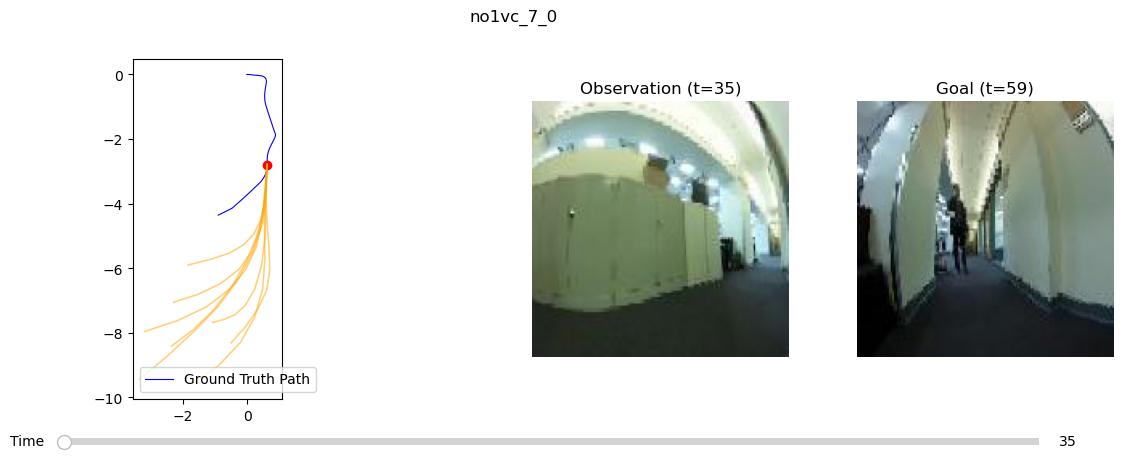

In [13]:
import os
import yaml
import requests
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.widgets import Slider
import io
import pickle

# --- Server API Configuration ---
BASE_URL = "http://127.0.0.1:8000"

def set_goal_image(goal_image_path: str):
    """Sends the goal image to the server."""
    with open(goal_image_path, "rb") as f:
        files = {"goal_image": (os.path.basename(goal_image_path), f, "image/jpeg")}
        response = requests.post(f"{BASE_URL}/set_goal_image/", files=files)
        response.raise_for_status()
    print("Goal image set on server.")

def add_observation_image(obs_image_path: str):
    """Adds a single observation image to the server's queue."""
    with open(obs_image_path, "rb") as f:
        files = {"observation_image": (os.path.basename(obs_image_path), f, "image/jpeg")}
        response = requests.post(f"{BASE_URL}/add_observation_image/", files=files)
        response.raise_for_status()

def clear_server_observations():
    """Clears the observation queue on the server."""
    response = requests.post(f"{BASE_URL}/clear_observations/")
    response.raise_for_status()

def get_waypoints_from_server():
    """Requests waypoints from the server."""
    response = requests.post(f"{BASE_URL}/generate_waypoints/")
    response.raise_for_status()
    return np.array(response.json()["waypoints"])

# --- Data Loading ---

def load_traj_data(traj_dir: str):
    """Load traj_data.pkl and return position (T x 2) and yaw (T,) arrays."""
    with open(os.path.join(traj_dir, "traj_data.pkl"), "rb") as f:
        data = pickle.load(f)
    positions = np.asarray(data["position"], dtype=float)
    yaw = np.asarray(data["yaw"], dtype=float)
    return positions, yaw

def load_image(traj_dir: str, idx: int):
    """Load idx.jpg from traj_dir."""
    img_path = os.path.join(traj_dir, f"{idx}.jpg")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image {img_path} not found")
    return Image.open(img_path)

# --- Plotting Functions ---

def setup_plot(pos_data, traj_dir_name):
    """
    Initializes the matplotlib figure and axes for visualization.
    """
    fig, (ax_path, ax_img, ax_goal) = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1, 1]})
    fig.suptitle(os.path.basename(traj_dir_name))
    plt.subplots_adjust(bottom=0.2)

    ax_path.plot(pos_data[:, 0], pos_data[:, 1], "b-", lw=0.8, label="Ground Truth Path")
    ax_path.set_aspect('equal', adjustable='box')
    ax_path.legend()

    pt, = ax_path.plot([], [], "ro")
    arrow = ax_path.quiver([], [], [], [], color="r", scale_units="xy", scale=1, headwidth=5)
    img_ax = ax_img.imshow(Image.new("RGB", (10, 10)))
    goal_ax_img = ax_goal.imshow(Image.new("RGB", (10, 10)))
    
    for ax in [ax_img, ax_goal]:
        ax.axis("off")

    artists = {
        'fig': fig, 'ax_path': ax_path, 'ax_img': ax_img, 'ax_goal': ax_goal,
        'pt': pt, 'arrow': arrow, 'img_ax': img_ax, 'goal_ax_img': goal_ax_img,
        'trajectory_plots': []
    }
    return fig, artists

def update_plot(artists, robot_pos, robot_yaw, obs_img, goal_img, waypoints):
    """
    Updates the plot with new data for a single timestep.
    """
    artists['pt'].set_data([robot_pos[0]], [robot_pos[1]])
    dx, dy = np.cos(robot_yaw), np.sin(robot_yaw)
    artists['arrow'].set_offsets(robot_pos)
    artists['arrow'].set_UVC(dx, dy)

    artists['img_ax'].set_data(obs_img)
    artists['goal_ax_img'].set_data(goal_img)

    for p in artists['trajectory_plots']:
        p.remove()
    artists['trajectory_plots'].clear()

    if waypoints is not None:
        rot_matrix = np.array([
            [np.cos(robot_yaw), -np.sin(robot_yaw)],
            [np.sin(robot_yaw),  np.cos(robot_yaw)]
        ])
        for i in range(waypoints.shape[0]):
            local_traj = np.vstack([[0, 0], waypoints[i]])
            world_traj = local_traj @ rot_matrix.T + robot_pos
            line, = artists['ax_path'].plot(world_traj[:, 0], world_traj[:, 1], color="orange", alpha=0.5, lw=1.2)
            artists['trajectory_plots'].append(line)

    artists['fig'].canvas.draw_idle()


if __name__ == "__main__":
    # -------- User Paths and Config --------
    # This path will need to be updated if it's incorrect
    traj_dir = "testdata/no1vc_7_0" 
    # The context size should ideally match the server's config.
    CONTEXT_SIZE = 4
    
    # -------- Load Trajectory Data --------
    try:
        pos_data, yaw_data = load_traj_data(traj_dir)
        T = len(pos_data)
    except FileNotFoundError as e:
        print(f"Error loading trajectory data: {e}")
        print("Please ensure the `traj_dir` path is correct and `traj_data.pkl` exists.")
        exit()

    # -------- Main Visualization Setup --------
    start_t = CONTEXT_SIZE+1+30
    goal_t = T - 1
    # goal_t = start_t+10
    
    # A small adjustment to prevent goal_t from being less than start_t
    if goal_t <= start_t:
        goal_t = start_t + 5
        print(f"Warning: Trajectory is very short. Setting goal_t to {goal_t}")
    
    goal_image_path = os.path.join(traj_dir, f"{goal_t}.jpg")
    
    try:
        goal_image = load_image(traj_dir, goal_t)
        set_goal_image(goal_image_path)
    except (requests.exceptions.RequestException, FileNotFoundError) as e:
        print(f"Error setting goal image: {e}")
        print("Please ensure the server is running and the `traj_dir` path is correct.")
        exit()

    fig, artists = setup_plot(pos_data, traj_dir)
    artists['ax_img'].set_title(f"Observation (t={start_t})")
    artists['ax_goal'].set_title(f"Goal (t={goal_t})")
    artists['goal_ax_img'].set_data(goal_image)

    # -------- Interactive Slider Logic --------
    def on_slider_change(t):
        t = int(t)
        
        robot_pos = pos_data[t]
        robot_yaw = yaw_data[t]
        current_obs_image = load_image(traj_dir, t)
        
        try:
            clear_server_observations()
            start_idx_for_queue = max(0, t - CONTEXT_SIZE)
            for i in range(start_idx_for_queue, t + 1):
                img_path = os.path.join(traj_dir, f"{i}.jpg")
                add_observation_image(img_path)
            
            waypoints = get_waypoints_from_server()
            
        except requests.exceptions.RequestException as e:
            print(f"Error communicating with server: {e}")
            waypoints = None
        
        update_plot(artists, robot_pos, robot_yaw, current_obs_image, goal_image, waypoints)
        artists['ax_img'].set_title(f"Observation (t={t})")

    # Create and connect the slider
    ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
    slider = Slider(
        ax=ax_slider, label='Time',
        valmin=start_t, valmax=goal_t - 1, valinit=start_t, valstep=1
    )
    slider.on_changed(on_slider_change)

    # Initial call to draw the first frame
    on_slider_change(start_t)

    plt.show() 